# Compatibility of wind turbines with RAS

## License

```
Wind turbine compatibility with RAS observations.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pycraf import conversions as cnv
from pycraf import pathprof, protection
from astropy import units as u
from astropy.utils.console import ProgressBar

## Using terrain data to determine exclusion zones
This is the second part of a How-To series on wind turbine compatibility with RAS. In the [first part](B01_wind_turbine_generic) we've seen how to calculate the *minimal coupling loss*, MCL, and inferred the necessary separation distances for the generic (=flat-Earth) case.

Here, we will look into a more specific example: Accounting for terrain information, which area around a radio telescope should be kept free of wind turbines of a certain height?

From the generic study, we already know the MCL. We'll again do our calculations for the 610-MHz RAS band, assuming that the CISPR-11 emission limits are exploited to the maximum over the full RAS band.

In [3]:
MCL_610 = 150.9 * cnv.dB

Use SRTM data to calculate attenuation maps around the Effelsberg 100-m radio telescope. We use a moderate hub height of 120 m. Nowadays, typical heights are 160 m, soon 200 m hub heights are expected.

In [4]:
lon_rt, lat_rt = 6.88361 * u.deg, 50.52483 * u.deg
map_size_lon, map_size_lat = 1.5 * u.deg, 1.5 * u.deg
map_resolution = 10. * u.arcsec

h_wt, h_rt = 120 * u.m, 50 * u.m  # Tx and Rx are well above clutter

frequency = 610 * u.MHz  # choose any frequency, you like
temperature = 293.15 * u.K
pressure = 1013. * u.hPa

timepercent = 2 * u.percent
zone_t, zone_r = pathprof.CLUTTER.UNKNOWN, pathprof.CLUTTER.UNKNOWN

In [5]:
# this will take a while!
hprof_cache = pathprof.height_map_data(
    lon_rt, lat_rt,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    zone_t=zone_t, zone_r=zone_r,
    )

In [6]:
results = pathprof.atten_map_fast(
    frequency,
    temperature,
    pressure,
    h_rt, h_wt,
    timepercent,
    hprof_cache,  # dict_like
    )

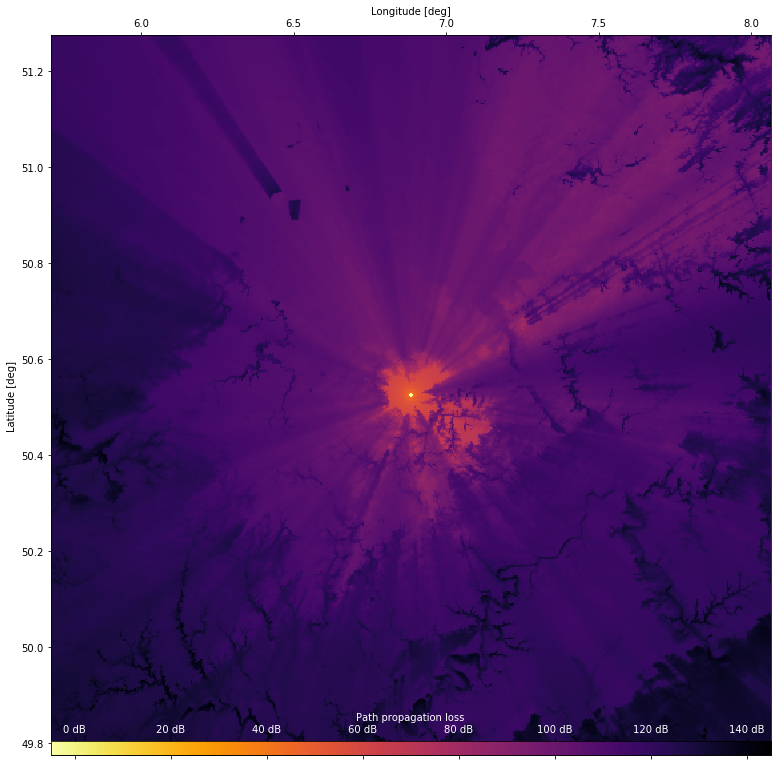

In [7]:
_lons = hprof_cache['xcoords']
_lats = hprof_cache['ycoords']
_total_atten = results['L_b']  # see description of atten_map_fast

vmin, vmax = 35, 185

plt.close()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _total_atten.to(cnv.dB).value,
    origin='lower', interpolation='nearest', cmap='inferno_r',
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Path propagation loss', color='w')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1line.set_visible(False)
    t.tick2line.set_visible(True)
    t.tick2line.set_color('w')
    t.label1.set_visible(False)
    t.label2.set_visible(True)
ctics = np.arange(0, 300, 20)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

From the attenuation map, it is fairly easy to calculate the margins. To improve the visualization, we are going to use a segmented colormap:

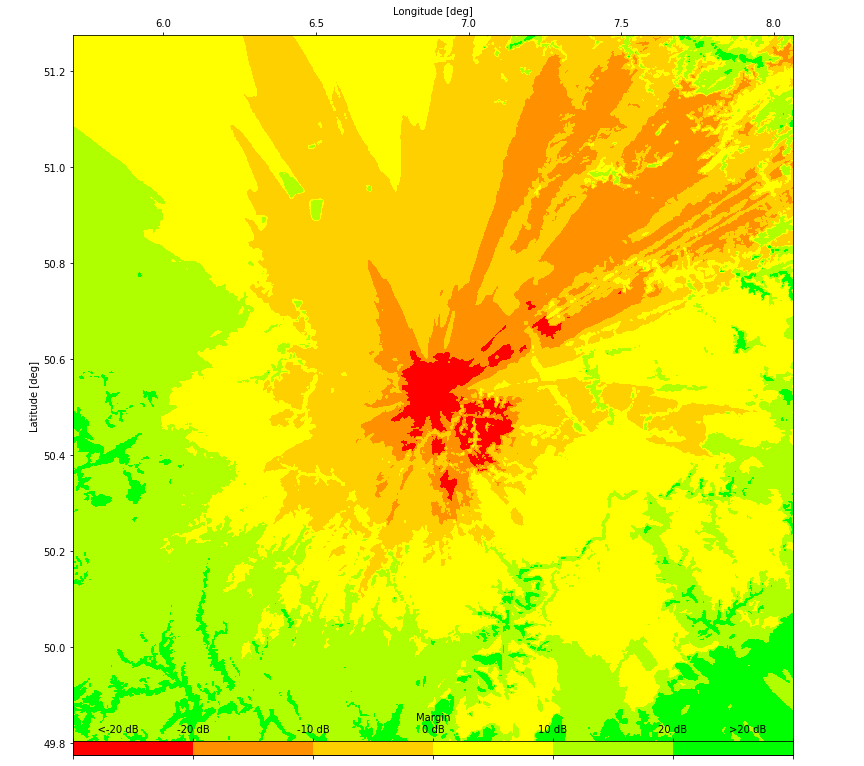

In [8]:
plt.close()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
ctics = [-200 , -20 , -10 , 0, 10, 20, 200]
ccolors = ['#ff0000', '#ff9000', '#ffd000', '#ffff00', '#b0ff00', '#00ff00']
cs = ax.contourf(
    _lons, _lats,
    _total_atten.to(cnv.dB).value - MCL_610.to(cnv.dB).value,
    ctics, colors=ccolors, origin='lower',
    )
plt.setp(cs.collections, rasterized=True)
cbar = fig.colorbar(
    cs, cax=cbax, orientation='horizontal'
    )
cbar.set_label(r'Margin', color='k')
cbax.xaxis.set_label_position('top')

ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
for t in cbax.xaxis.get_major_ticks():
    t.tick1line.set_visible(True)
    t.tick2line.set_visible(True)
    t.label1.set_visible(False)
    t.label2.set_visible(True)

cbar.set_ticks(ctics)
clabels = ['{:.0f} dB'.format(ct) for ct in ctics]
clabels[0] = '                             <-20 dB'  # OMG, this is ugly
clabels[-1] = '>20 dB                             '
cbar.ax.set_xticklabels(clabels, color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlim((_lons[0], _lons[-1]))
ax.set_ylim((_lats[0], _lats[-1]))
plt.show()

Every wind turbine located in a zone that is orange or darker (i.e., below 0 dB margin) would potentially lead to interference at the radio telescope. If emissions would be 20-dB below CISPR-11, only the red area is critical.